In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import fortitudo.tech as ft

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()

AU9999 = pd.read_excel('AU9999_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999}

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= '2008-01-01') & (index['交易时间'] <= '2023-01-01')]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for index, row in indices['A300'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['A300'].drop(index = index, inplace = True)
        indices['A500'].drop(index = index, inplace = True)
        indices['AU9999'].drop(index = index, inplace = True)
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['A300'].index.values:
            indices['A300'].drop(index = index, inplace = True)
        if index in indices['A500'].index.values:
            indices['A500'].drop(index = index, inplace = True)
        if index in indices['AU9999'].index.values:
            indices['AU9999'].drop(index = index, inplace = True)

for index, row in indices['SPX'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['SPX'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['SPX'].index.values:
            indices['SPX'].drop(index = index, inplace = True)

for index, row in indices['HSI'].iterrows():
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        indices['HSI'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['HSI'].index.values:
            indices['HSI'].drop(index = index, inplace = True)

for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [4]:
# 应该确保不同区域市场时间序列大小一致
index_shape = set()
for name, index in indices.items():
    index_shape.add(index.shape[0])
if len(set(index_shape)) == 1:
    print('Pass')
else:
    print('Fail')

Pass


## 统计特征

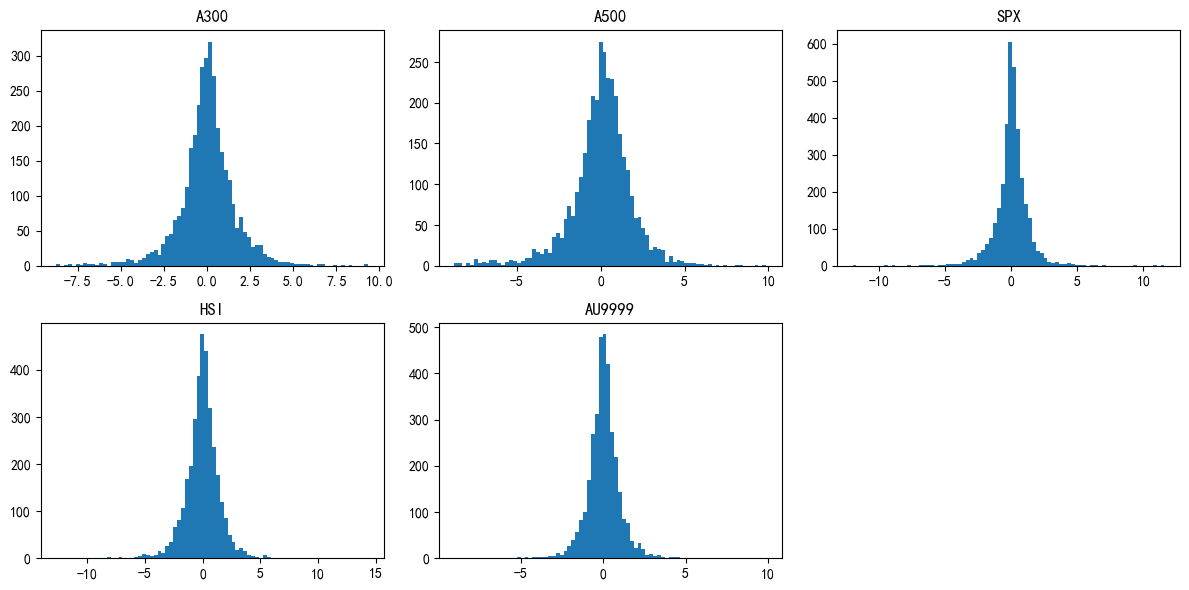

In [5]:
# 分布直方图

fig = plt.figure(figsize=(12, 6))
i = 1
for name, index in indices.items():
    ax = plt.subplot(2, 3, i)
    ax.set_title(name)
    plt.tight_layout()
    plt.hist(np.array(index['涨跌幅%']), bins=80)
    i += 1

In [6]:
pnls = np.array([[0] * 3460])
names = []
for name, index in indices.items():
    print(name, end=' ')
    names.append(name)
    pnls = np.r_[pnls, np.array(index['涨跌幅%']).reshape(1,-1)]
pnls = pnls[1:].astype('float16').T

A300 A500 SPX HSI AU9999 

In [7]:
# 计算期望与协方差

Mu = pnls.mean(axis = 0).reshape(-1, 1)
Sigma = np.cov(pnls.T)
display(pd.DataFrame(np.round(np.corrcoef(pnls.T), 2), columns=names, index=names))   # 相关系数矩阵
display(pd.DataFrame(np.round(Sigma, 2), columns=names, index=names))  # 协方差矩阵

,A300,A500,SPX,HSI,AU9999
A300,1.00,0.88,0.12,0.55,0.05
A500,0.88,1.00,0.08,0.43,0.04
SPX,0.12,0.08,1.00,0.24,0.00
HSI,0.55,0.43,0.24,1.00,0.09
AU9999,0.05,0.04,0.00,0.09,1.00


,A300,A500,SPX,HSI,AU9999
A300,2.68,2.68,0.25,1.38,0.08
A500,2.68,3.46,0.21,1.23,0.08
SPX,0.25,0.21,1.72,0.49,0.00
HSI,1.38,1.23,0.49,2.36,0.13
AU9999,0.08,0.08,0.00,0.13,1.03


In [8]:
# 正态性检验

alpha = 0.05
print("W正态性检验")
for i in range(pnls.shape[1]):
    if (scipy.stats.shapiro(pnls[:, i])[1] <= alpha):
        print(names[i], '非正态')
    else:
        print(names[i], '正态')

print("\nK-S正态性检验")
for i in range(pnls.shape[1]):
    if (scipy.stats.kstest(pnls[:, i], cdf='norm')[1] <= alpha):
        print(names[i], '非正态')
    else:
        print(names[i], '正态')

W正态性检验
A300 非正态
A500 非正态
SPX 非正态
HSI 非正态
AU9999 非正态

K-S正态性检验
A300 非正态
A500 非正态
SPX 非正态
HSI 非正态
AU9999 非正态


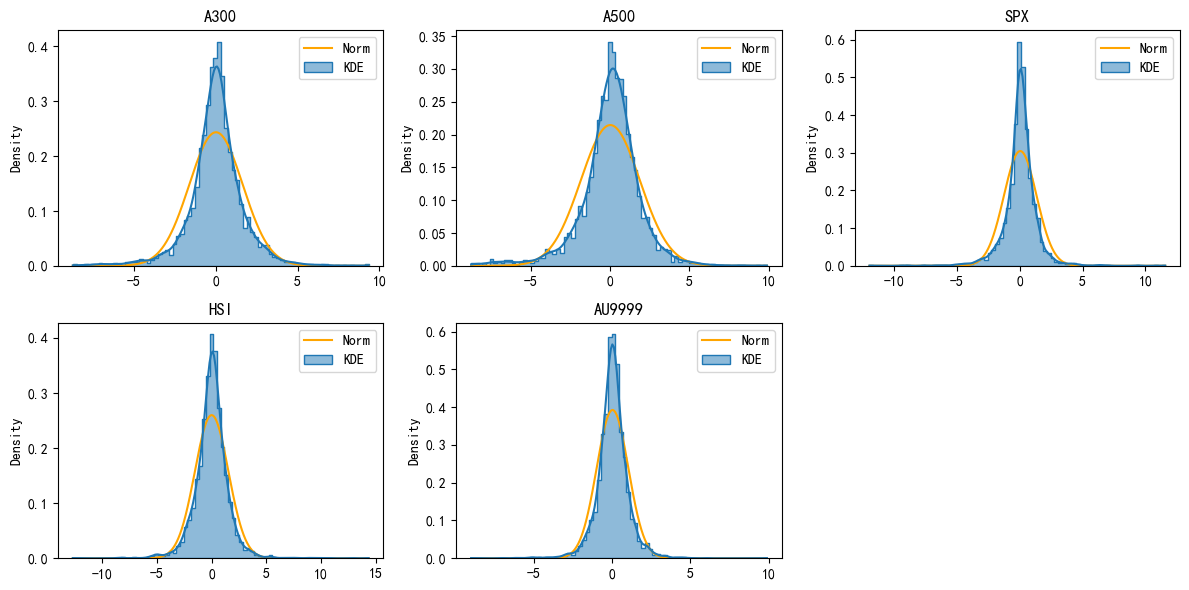

In [9]:
# 分布图
# 蓝色直方图，深蓝色核密度函数，橙色正态密度函数

fig = plt.figure(figsize=(12, 6))
i = 0
for name, index in indices.items():
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    pnl = np.array(index['涨跌幅%'])
    norm_x = np.linspace(pnl.min(), pnl.max(), 1000)
    norm_y = scipy.stats.norm.pdf(norm_x, Mu[i], np.sqrt(Sigma[i,i]))
    plt.plot(norm_x,norm_y,c="orange", label='Norm')
    sns.histplot(data = pnl, bins = 80, kde=True, ax = ax, element="step", stat="density", label='KDE')
    plt.legend()
    i += 1

## 熵池模型
熵池(Entropy Pooling, EP)模型通过相对熵(Relative Entropy, RE)来衡量分布之间的距离，最小化嵌入了观点和市场影响因素的后验分布和先验分布之间的RE距离来剔除多余观点，得到符合观点表述的最简后验分布。

## 解析解
正态先验总体的解析解，得到后验正态总体。

In [10]:
def prior2posterior(mu, q, mu_q, sigma, g, sigma_g):
    """
    Analytical solution to the constrain
    X ~ (Mu, Sigma)
    E(QX) = Mu_Q
    Cov(GX) = Sigma_G
    
    minimize the KL divergence
    
    X ~ (Mu_tilda, Sigma_tilda)
    
    See the following paper for more details.

    Meucci, Attilio, Fully Flexible Views: Theory and Practice (August 8, 2008). 
    Fully Flexible Views: Theory and Practice, Risk, Vol. 21, No. 10, pp. 97-102, October 2008. 
    Available at SSRN: https://ssrn.com/abstract=1213325
    
    
    """
    mu_tilda = sigma * q.T * np.linalg.inv(q * sigma * q.T) * (mu_q - q * mu)
    tmp = np.linalg.inv(g * sigma * g.T)
    sigma_tilda = sigma + (sigma * g.T) * (tmp * sigma_g * tmp - tmp) * (g*sigma)
    return mu_tilda, sigma_tilda

In [11]:
# 给定观点（随便设置的）
# 可将数值设置大（可能没有现实意义）一些以清晰看出图形变化

# 控制变量进行简单观点测试
# 发现即使只对一个量引入观点也会导致其他相关量变化
# 相关性越强变化越大
# Q = np.matrix([[1, 0, 0, 0, 0]])
# Mu_Q = np.array([1.1*Mu[0]+0.4]).reshape(-1, 1)  

# 复杂观点测试
Q = np.matrix([[1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 1, -1, 0],
               [1, 0, 0, 0, 1]])
Mu_Q = np.array([Mu[0]-0.3,
                 Mu[1]+0.5,
                 0.9*Mu[2] - 1.5*Mu[3] - 0.2,
                 1.1*Mu[0] + 0.9*Mu[1] - 0.4]).reshape(-1, 1)   

G = np.eye(5)
Sigma_G = 1.1 * Sigma   # 调整协方差矩阵以引入波动率，也可以引入其他线性组合的协方差

Mu_tilda, Sigma_tilda = prior2posterior(Mu, Q, Mu_Q, Sigma, G, Sigma_G)
Mu_tilda = np.array(Mu_tilda)

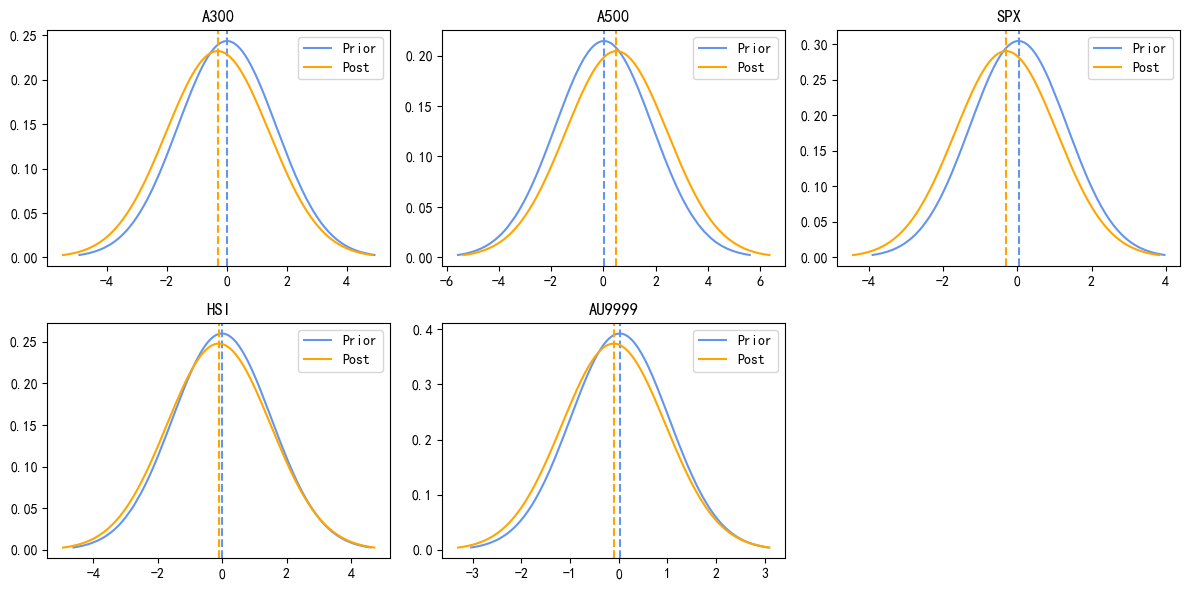

In [12]:
# 分布图
# 蓝色先验分布，橙色后验分布
# 结果不知道为什么均值一直是0

fig = plt.figure(figsize=(12, 6))
for i, name in enumerate(names):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    
    prior_norm_x = np.linspace(Mu[i] - 3 * np.sqrt(Sigma[i,i]),
                         Mu[i] + 3 * np.sqrt(Sigma[i,i]), 1000)
    post_norm_x = np.linspace(Mu_tilda[i] - 3 * np.sqrt(Sigma_tilda[i,i]),
                         Mu_tilda[i] + 3 * np.sqrt(Sigma_tilda[i,i]), 1000)
    
    prior_norm_y = scipy.stats.norm.pdf(prior_norm_x, Mu[i], np.sqrt(Sigma[i,i]))
    post_norm_y = scipy.stats.norm.pdf(post_norm_x, Mu_tilda[i], np.sqrt(Sigma_tilda[i,i]))
    
    plt.plot(prior_norm_x,prior_norm_y,c="cornflowerblue", label = 'Prior')
    plt.axvline(x=Mu[i], linestyle='--',c="cornflowerblue")
    plt.plot(post_norm_x,post_norm_y,c="orange", label='Post')
    plt.axvline(x=Mu_tilda[i], linestyle='--', c="orange")
    plt.legend()

## 数值解1
EP是通过minimize RE来获得市场后验分布，但是大部分情况下总体的分布并不能被看作正态的，此时计算EP的解析解是困难的，因此需要数值解法来得到更具应用普遍性的结果

最优化任务：$argmin_{f} KL(f, g)$, g s.t. constraints，constraints为观点

也就是在函数空间内搜索一个与先验分布最相似但是满足constraints的分布

数值的方法是通过建造一个Panel $V$来表示分布

$V$ 其实就是讲市场的信息（回报率，价格，因子等等），通过观点function $g_k(...)$ 映射得来

$V_{j,k} = g_k(X_{j,1}, ..., X_{j,N})$

对于一个这样的panel, 可以形成一个JX1的向量，用来代表每个scenario下的概率，$p$  
而后验分布$\widetilde{p}$，则是我们需要通过优化得到的，用它来minimize KL-divergence

其中k代表k个观点，而j代表的是simultaion的数量  
而RE距离的连续形式可以被改成离散的形式
$E(\widetilde{p}, p) = \sum_{j=1}^J \widetilde{p}_j[ln(\widetilde{p}_j) - ln(p_j)]$

但是在Meucci的第二篇文章Fully Exterme Views中，没有采用Monte Carolo Simulation去获得V panel
而是采用类似于Grid Search的方式
作者这里使用的是Hermite Polynomial的零点作为grid

这里计算直接使用了eqaully spaced的interval

In [13]:
def kde_scipy(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = scipy.stats.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde

def kernelbw(x):
    # Bandwith 计算
    n = len(x)
    prop = 1.0
    sig = np.std(x)
    iqrSig = 0.7413 * scipy.stats.iqr(x)
    if iqrSig == 0:
        iqrSig = sig
    bw = prop * min(sig, iqrSig) * n ** (-1/(4+1))
    return bw

def kernelpdf(x, xi, wi):
    n = len(xi)
    bw = kernelbw(xi)
    
    p = np.zeros(len(x))
    for i in range(n):
        p = p + wi[i] * scipy.stats.norm.pdf(x, loc=xi[i], scale = bw);
    return p

def kernelcdf(x, xi, wi):
    np.seterr(divide = 'ignore')    # 关闭计算警告
    n = len(xi)
    bw = kernelbw(xi)
    if type(x) is not np.ndarray:
        p = np.zeros(1)
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p[0]
    else:
        p = np.zeros(len(x))
        for i in range(n):
            p = p + np.exp(np.log(wi[i]) + np.log(scipy.stats.norm.cdf(x, loc=xi[i], scale=bw)))
        return p
    np.seterr(divide = 'warn')    # 还原计算警告

def kernelinv(p, xi, wi):
    import collections.abc
    
    def helper(x, xi, wi, p):
        f = kernelcdf(x, xi, wi) - p
        return f

    if not isinstance(p, collections.abc.Iterable):
        sortp = p
        x = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp))
        return x
    elif len(p) < 10:
        x = np.zeros(len(p))
        tmp = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, p[0]))
        for i in range(len(p)):
            x[i] = tmp
        return x
    else:
        sortp = np.sort(p)
        x_min = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp[0]))
        x_max = scipy.optimize.newton(helper, x0 = 1, args=(xi, wi, sortp[len(sortp)-1]))
    
        # mesh for x values
        x_ = np.linspace(x_min - 0.1 * abs(x_min), x_max + 0.1 * abs(x_max), 500)

        # evaluates the mesh on these values
        y_ = kernelcdf(x_, xi, wi);
        x = np.interp(p, y_, x_)
        return x
    
def subIntervals(x):
    n = len(X)
    xMesh = np.empty(n+1)
    xMesh[0] = X[0]
    xMesh[n] = X[n-1]
    xMesh[1:n] = X[1:] - 0.5 * (X[1:] - X[0:n-1])

    xUB = xMesh[1:] - 2.2e-308
    xLB = xMesh[0: n] 
    return xUB, xLB
def intergrateSubIntervals(x, cdf):
    xUB, xLB = subIntervals(X)
    p = (cdf(xUB) - cdf(xLB)) 
    return p

def normalizeProb(p):
    tol = 1e-20
    tmp = p
    tmp[tmp<tol] = tol
    return tmp / sum(tmp)

In [14]:
# 这里以沪深300指数为例
xi = np.array(indices['A300']['涨跌幅%'])
n = xi.shape[0]

# bandwith
bw = kernelbw(xi)

# weights
lamb = np.log(2) / (n / 2);
wi = np.exp(-lamb * np.array(range(n)))
wi = np.array(list(reversed(wi))) / sum(wi)

mu = np.mean(xi)
pdf = lambda x: kernelpdf(x, xi, wi)
cdf = lambda x: kernelcdf(x, xi, wi)
inv = lambda x: kernelinv(x, xi, wi)
VaR95 = inv(0.05)

J = 10000
tmp = np.linspace(0, 1, 1000)
epsilon = 1e-10
Lower = inv(epsilon)
Upper = inv(1 - epsilon)
# X = Lower + tmp * (Upper - Lower)

delta = (Upper - Lower) / J
X = np.array([Lower + (2*j - 1) / 2 * delta for j in range(1, J+1)])

p = intergrateSubIntervals(X, cdf)
# p = normalizeProb(p)

In [15]:
def nestedfunU(v):
    global lnp, Aeq, Beq
    v = v.reshape((v.shape[0], 1))

    lnx = lnp - 1 - Aeq.T * v
    
    x = np.exp(lnx)
    L = x.T * (lnx - lnp + Aeq.T * v) - Beq.T * v

    return -L[0, 0]   

Mean: Prior 0.00939, Post 1.00939
Var: Prior 2.68181, Post 7.68182


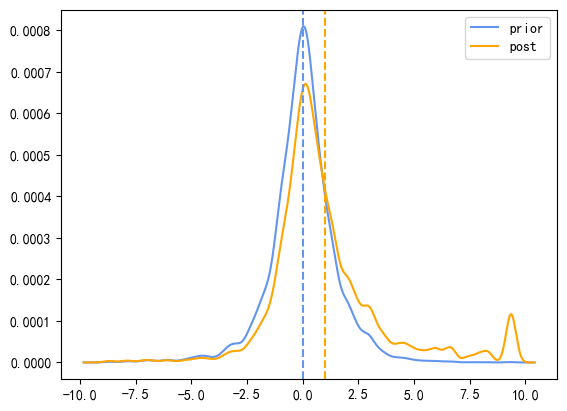

In [16]:
# Constraints

view_mu = np.mean(xi) + 1     # 收益率和波动都增加很多的情况
view_variance = np.var(xi) + 5
Aeq = np.matrix([np.ones(J), X**2, X])
Beq = np.matrix([1, view_variance, view_mu]).T

lnp = np.matrix(np.log(p)).T 

x0 = [np.random.random() for _ in range(3)]
res = scipy.optimize.minimize(nestedfunU, x0, method='BFGS', tol=1e-10)
v = res.x
v = v.reshape((v.shape[0], 1))
lnp_ = lnp - 1 - Aeq.T * v
p_ = np.array(np.exp(lnp_)).reshape(lnp_.shape[0])

prior_mean = np.dot(X, p)
posterior_mean = np.dot(X, p_)
posterior_var = np.dot(X**2, p_)

print('Mean: Prior %.5f, Post %.5f' % (np.mean(xi), posterior_mean))

print('Var: Prior %.5f, Post %.5f' % (np.var(xi), posterior_var))

plt.plot(X, p, label = 'prior', c="cornflowerblue")
plt.plot(X, p_, label = 'post', c="orange")
plt.axvline(x=np.mean(xi), linestyle='--',c="cornflowerblue")
plt.axvline(x=posterior_mean, linestyle='--',c="orange")

plt.legend()

## 数值解2
这里直接使用 fortitudo.tech 库

In [17]:
R_df = pd.DataFrame(data=pnls, columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(np.round(stats_prior, 2))

corr_prior = ft.correlation_matrix(R_df)
display(np.round(corr_prior, 2))

原始数据


,Mean,Volatility,Skewness,Kurtosis
A300,0.01,1.64,-0.31,7.12
A500,0.02,1.86,-0.69,6.66
SPX,0.03,1.31,-0.20,14.96
HSI,-0.00,1.54,0.37,12.32
AU9999,0.02,1.02,-0.24,11.57


,0,1,2,3,4
"(0, A300)",1.00,0.88,0.12,0.55,0.05
"(1, A500)",0.88,1.00,0.08,0.43,0.04
"(2, SPX)",0.12,0.08,1.00,0.24,0.00
"(3, HSI)",0.55,0.43,0.24,1.00,0.09
"(4, AU9999)",0.05,0.04,0.00,0.09,1.00


### 先验情景分布为均匀分布的情况
离散情景先验分布可以认为是均等的，因此一般采用均匀分布即可。

In [18]:
R = R_df.values
S = R.shape[0]
p = np.ones((S, 1)) / S    # 均匀分布
means_prior = p.T @ R      # 先验均值
vols_prior = np.sqrt(p.T @ (R - means_prior)**2)    # 先验标准差和样本标准差差距很大

A300_A500_mean = (R[:, 0]-R[:, 1])[np.newaxis, :]   # A300和A500均值之差
A300_mean = (R[:, 0])[np.newaxis, :]
A500_mean = (R[:, 1])[np.newaxis, :]
SPX_mean = R[:, 3][np.newaxis, :]
HSI_kurt = (((R[:, 2] - means_prior[:, 2]) / vols_prior[:, 2])**4)[np.newaxis, :]
A500_kurt = (((R[:, 1] - means_prior[:, 1]) / vols_prior[:, 1])**4)[np.newaxis, :]

A = np.vstack((np.ones((1, S)), A300_A500_mean, A500_kurt))   # 等式约束设置
b = np.vstack(([1.0], [0.02], [7.0]))                # 第一项约束为离散分布和为1
G = np.vstack((SPX_mean, -HSI_kurt, -A300_mean, -A500_mean))
h = np.vstack(([0.01], [-12], [-0.03], [-0.05]))

q = ft.entropy_pooling(p, A, b, G, h)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)

print(f'ENS = {np.round(effective_number_scenarios[0, 0] * 100, 2)}%.')
print(f'RE = {np.round(relative_entropy[0, 0] * 100, 2)}%.')

stats_post = ft.simulation_moments(R_df, q)
display(np.round(stats_post, 2))

corr_post = ft.correlation_matrix(R_df, q)
display(np.round(corr_post, 2))

ENS = 99.85%.
RE = 0.15%.


,Mean,Volatility,Skewness,Kurtosis
A300,0.07,1.66,-0.15,7.20
A500,0.05,1.88,-0.60,6.71
SPX,0.03,1.31,-0.18,14.86
HSI,0.01,1.54,0.36,12.31
AU9999,0.02,1.02,-0.22,11.45


,0,1,2,3,4
"(0, A300)",1.00,0.88,0.12,0.55,0.05
"(1, A500)",0.88,1.00,0.09,0.43,0.04
"(2, SPX)",0.12,0.09,1.00,0.24,-0.00
"(3, HSI)",0.55,0.43,0.24,1.00,0.08
"(4, AU9999)",0.05,0.04,-0.00,0.08,1.00


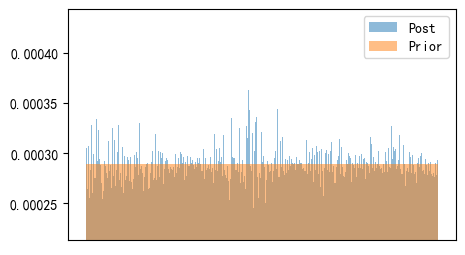

In [19]:
fig = plt.figure(figsize=(5, 3))
plt.ylim((q.min(), q.max()))
plt.bar(x = np.arange(q.shape[0]), height = q.reshape(-1), width=1, alpha=0.5, label='Post')
plt.bar(x = np.arange(p.shape[0]), height = p.reshape(-1), width=1, alpha=0.5, label='Prior')
plt.xticks([])
plt.legend()

## Ornstein-Ulenbeck过程

In [47]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [48]:
def OU_MLE(time_series, dt, N):
    """
    Use Minimal Likelihood Estimation for OU process parameter
    """
    XX = time_series[:-1]
    YY = time_series[1:]
    
    Sx = np.sum(XX)
    Sy = np.sum(YY)
    Sxx = XX @ XX
    Sxy = XX @ YY
    Syy = YY @ YY

    mu_mle = (Sy*Sxx - Sx*Sxy) / (N*(Sxx-Sxy) - (Sx**2 - Sx*Sy) )
    theta_mle = -1/dt * np.log( (Sxy - mu_mle*Sx - mu_mle*Sy +N*mu_mle**2) 
                              / (Sxx - 2*mu_mle*Sx + N*mu_mle**2)  )
    sigma2_hat = ( Syy -2*np.exp(-theta_mle*dt)*Sxy + np.exp(-2*theta_mle*dt)*Sxx - 2*mu_mle*
                 (1-np.exp(-theta_mle*dt))*(Sy-np.exp(-theta_mle*dt)*Sx) + N*mu_mle**2 * 
                  (1-np.exp(-theta_mle*dt))**2 )/N
    sigma_mle = np.sqrt(sigma2_hat * 2*theta_mle / (1-np.exp(-2*theta_mle*dt)))
    
    return mu_mle * theta_mle, theta_mle, sigma_mle

In [26]:
N = 500

mu = []
theta = []
sigma = []

for i in range(prices.shape[0]):
    _mu, _theta, _sigma  = OU_MLE(prices[i][:N], 1, N)
    mu.append(_mu)
    theta.append(_theta)
    sigma.append(_sigma)
print("Mu:", mu)
print("Theta:", theta)
print("Sigma:",sigma)

Mu: [32.05000879699168, 22.028674621353087, 8.846394047579018, 206.0747641582441, 1.5151459946701917]
Theta: [0.011830028298727743, 0.006784687972997859, 0.00881664288847224, 0.011256166269029465, 0.006847472745021834]
Sigma: [85.14846760766847, 101.15326532447436, 22.15326497092208, 500.0235441500671, 3.2023290172131937]


## 技术指标

In [78]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

In [138]:
R3 =  RSI(prices[0], price_moves[0], period = 3)
R12 =  RSI(prices[0], price_moves[0], period = 12)
R6 =  RSI(prices[0], price_moves[0], period = 6)

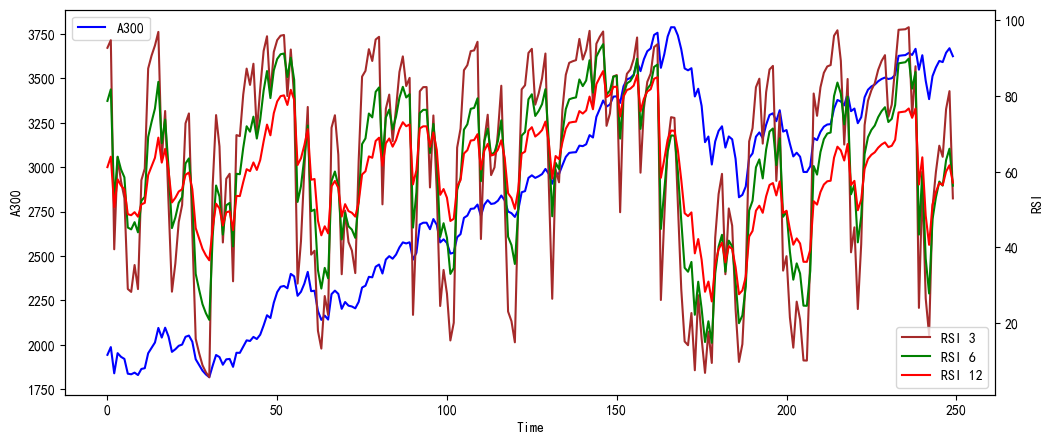

In [142]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('A300')
ax.plot(np.arange(R12[200:450].shape[0]), prices[0][200:450],color = 'blue', label = 'A300')
ax2 = ax.twinx()
ax2.set_ylabel('RSI')
ax2.plot(np.arange(R3[200:450].shape[0]), R3[200:450], color = 'brown', label = 'RSI 3')
ax2.plot(np.arange(R6[200:450].shape[0]), R6[200:450], color = 'green', label = 'RSI 6')
ax2.plot(np.arange(R12[200:450].shape[0]), R12[200:450], color = 'red', label = 'RSI 12')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')